In [1]:
# !pip install catboost optuna



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.8 MB/s eta 0:00:00










     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.1 MB/s eta 0:00:00









     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00

















In [3]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, pairwise_distances
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

import optuna

from scipy.spatial.distance import pdist, squareform

import pickle

from scipy.sparse import csr_matrix, coo_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

#### General

In [11]:
datapath = './data/' # local
# datapath = r'/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/' # colab
# datapath = r'/kaggle/input/drivendata-earthquake/' # kaggle

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [12]:
def preprocess(df_features):
    # Convert numeric features to float
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

In [13]:
# Feature groups
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
# non_geo_features_w_label = categorical_features + numerical_features + ['damage_grade']
# for geo_feat in geo_features:
#     non_geo_features_w_label.remove(geo_feat)

### AutoEncode Geography (Pytorch)

#### Impute damage_grade of test features

In [14]:
def impute_damage_grade(df_train_X: pd.DataFrame,df_val_X: pd.DataFrame,
                        df_test_X: pd.DataFrame,df_pred_X: pd.DataFrame,
                        df_train_y: pd.DataFrame) -> pd.DataFrame:
    '''
    Impute damage grade based on location (i.e. the three geo features). This function
    
    The original dataset
    should first be split into train, val and test sets. The imputation will be done using all
    features from all datasets, but only labels from the train dataset to prevent date leakage.
    df_train_X: Post splitting X dataframe for training
    df_val_X: Post splitting X dataframe for validation set
    df_test_X: Post splt

    '''
    # Preprocess to convert numerical features to float
    df_train_X = preprocess(df_train_X.copy())
    df_val_X = preprocess(df_val_X.copy())
    df_test_X = preprocess(df_test_X.copy())
    df_pred_X = preprocess(df_pred_X.copy())

    df_all = pd.concat([df_train_X,df_train_y],axis=1)
    df_all = pd.concat([df_all,df_val_X,df_test_X,df_pred_X],axis=0)

    df_all['geo_combined3'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']) + '_' + str(row['geo_level_3_id']), axis=1)
    df_all['geo_combined2'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']), axis=1)

    # Fillna for damage_grade with means for geo level 3
    damage_means3 = df_all.groupby('geo_combined3')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means3[row['geo_combined3']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Fillna for damage_grade with means for lowest geo level 2
    damage_means2 = df_all.groupby('geo_combined2')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means2[row['geo_combined2']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Fillna for damage_grade with means for lowest geo level 2
    damage_means1 = df_all.groupby('geo_level_1_id')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means1[row['geo_level_1_id']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Drop unwanted columns
    df_all.drop(columns=['geo_combined2','geo_combined3'],inplace=True)
    df_all = pd.get_dummies(df_all,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)

    # Get feature names
    non_geo_features_OHE = [col for col in df_all.columns if not (col in geo_features)]


    return df_all, non_geo_features_OHE

In [15]:
# Split into train, val, and test sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y)

#### Geo-features + other categorical features
To iterate over:
1. architecture and weights
2. latent size
3. Number of epochs

In [21]:
# geo1_n_geo2_n_geo3_n_int_n_lat_n_epo_n

# geo_n_lat_n = [(16,32,64,128,64),(16,32,64,128,32),(16,32,64,128,16),(16,32,64,128,8),(16,32,64,128,4)]
# geo_n_lat_n += [(8,16,32,64,32),(8,16,32,64,16),(8,16,32,64,8),(8,16,32,64,4)]
# geo_n_lat_n += [(4,8,16,64,32),(4,8,16,64,16),(4,8,16,64,8),(4,8,16,64,4)]
# epo_n = [1,2,4,8,10,12,16,20,25,30,40]


In [33]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    def __init__(self, geo1_size, geo2_size, geo3_size, inter_size, latent_size):
        super(CategoricalAutoencoder, self).__init__()
        self.geo1_size = geo1_size
        self.geo2_size = geo2_size
        self.geo3_size = geo3_size

        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, geo1_size)
        self.embed2 = nn.Embedding(1418, geo2_size)
        self.embed3 = nn.Embedding(11861, geo3_size)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(geo1_size + geo2_size + geo3_size + 58, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, geo1_size + geo2_size + geo3_size + 58)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(geo1_size, 31)
        self.output2 = nn.Linear(geo2_size, 1418)
        self.output3 = nn.Linear(geo3_size, 11861)
        
    def forward(self, x1, x2, x3, feats):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3, feats], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [self.geo1_size, self.geo2_size, self.geo3_size, 58], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out, feats_recon

def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute the loss
            loss = criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch)
            
            loss_feat = nn.MSELoss()(feats_recon, feats_batch)

            total_loss = loss + loss_feat

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3

latent_geo, model, dataset, x1, x2, x3 = get_latent_geo(df_all, non_geo_features_OHE)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.85it/s]


Epoch [1/10], Loss: 6.725572063926394


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.42it/s]


Epoch [2/10], Loss: 0.4411960254575569


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.23it/s]


Epoch [3/10], Loss: 0.21859940578159773


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.28it/s]


Epoch [4/10], Loss: 0.15774667626575997


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.52it/s]


Epoch [5/10], Loss: 0.11359433622671421


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.94it/s]


Epoch [6/10], Loss: 0.08847480125084728


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.69it/s]


Epoch [7/10], Loss: 0.08202774688302826


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.09it/s]


Epoch [8/10], Loss: 0.09013341309208511


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.09it/s]


Epoch [9/10], Loss: 0.054225844943680594


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.13it/s]


Epoch [10/10], Loss: 0.06360940829269857


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1644.71it/s]


Evaluating:   7%|▋         | 200/2715 [00:00<00:03, 632.22it/s]


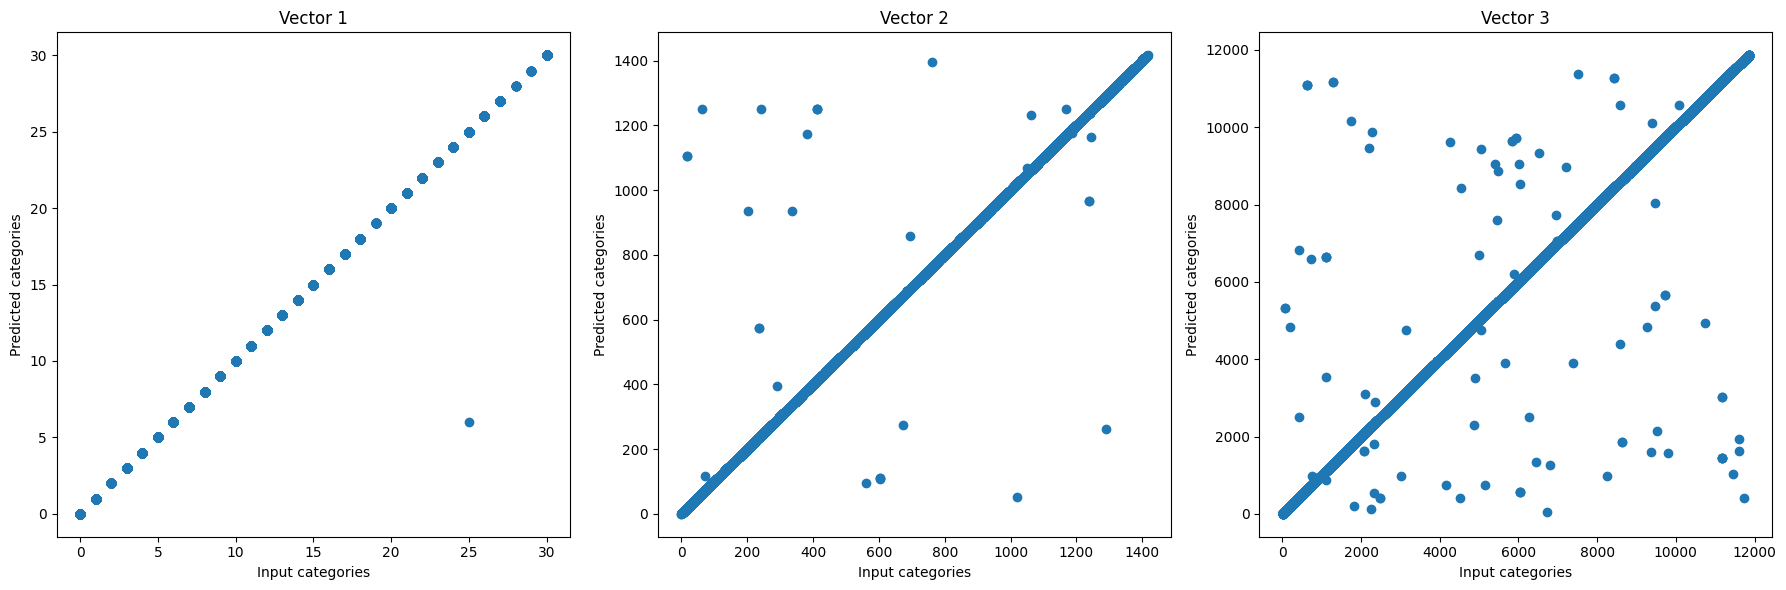

In [34]:
# Pass the input through the encoder and plot the results
model.eval()
z_list = []
recon_x1_list = []
recon_x2_list = []
recon_x3_list = []

eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)


counter = 0
with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc='Evaluating'):
        counter += 1
        if counter > 200:
            break
        x1_batch, x2_batch, x3_batch, feat_tensor = batch
        
        # Forward pass
        x1_out, x2_out, x3_out, _ = model(x1_batch, x2_batch, x3_batch, feat_tensor)
        z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                           model.embed2(x2_batch),
                                           model.embed3(x3_batch),
                                           feat_tensor],
                                           dim=1))
    
        # Move tensors to CPU
        z_list.append(z_batch.cpu())
        recon_x1_list.append(x1_out.cpu())
        recon_x2_list.append(x2_out.cpu())
        recon_x3_list.append(x3_out.cpu())
        
        # Clear cache
        torch.cuda.empty_cache()

# Concatenate results
z = torch.cat(z_list, dim=0)
recon_x1 = torch.cat(recon_x1_list, dim=0)
recon_x2 = torch.cat(recon_x2_list, dim=0)
recon_x3 = torch.cat(recon_x3_list, dim=0)

# Plot the input categories against the predicted categories
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot for the first vector
axs[0].scatter(x1[:recon_x1.shape[0]].cpu().numpy(), recon_x1.argmax(dim=1).cpu().numpy())
axs[0].set_xlabel('Input categories')
axs[0].set_ylabel('Predicted categories')
axs[0].set_title('Vector 1')

# Subplot for the second vector
axs[1].scatter(x2[:recon_x1.shape[0]].cpu().numpy(), recon_x2.argmax(dim=1).cpu().numpy())
axs[1].set_xlabel('Input categories')
axs[1].set_ylabel('Predicted categories')
axs[1].set_title('Vector 2')

# Subplot for the third vector
axs[2].scatter(x3[:recon_x1.shape[0]].cpu().numpy(), recon_x3.argmax(dim=1).cpu().numpy())
axs[2].set_xlabel('Input categories')
axs[2].set_ylabel('Predicted categories')
axs[2].set_title('Vector 3')

plt.tight_layout()
plt.show()

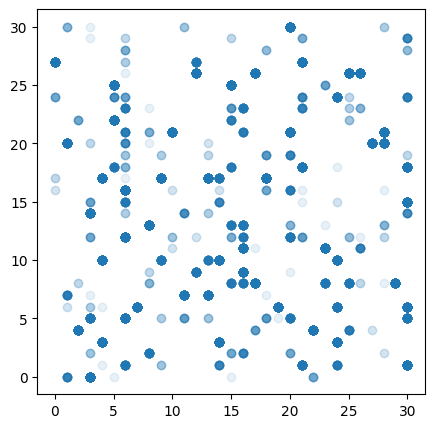

In [35]:
latent_geo = pd.concat([df_all[geo_features],pd.DataFrame(z.cpu().numpy())],axis=1)
latent_geo = pd.concat([df_all[geo_features].iloc[:recon_x1.shape[0],:].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)

np.random.seed(0)
num_samples = latent_geo.shape[0]
num_features = latent_geo.shape[1]-3
data = latent_geo.iloc[:,3:].to_numpy()

# Step 1: Normalize data (optional but recommended)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 2: Calculate cosine similarity-like metric (Euclidean distance in this case)
# Note: Cosine similarity is not directly applicable to numeric data, using Euclidean distance instead
# euclidean_sim = pairwise_distances(data_scaled, metric='euclidean')
cosine_sim = 1 - pairwise_distances(data_scaled, metric='cosine')

# Step 3: Apply K-means clustering
num_clusters = 31  # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(cosine_sim)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(cluster_labels,latent_geo['geo_level_1_id'],alpha=0.1)

In [ ]:

    with open('latent_geo_1.pkl','wb') as f:
        pickle.dump(latent_geo,f)

Evaluating: 100%|██████████| 2715/2715 [00:04<00:00, 630.32it/s]


## CatBoost
Quick check with vanilla approach

In [7]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_test_features = preprocess(df_test_features_raw)

X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
 
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=X_val, label=y_val, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

In [17]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU',devices='0',metric_period=100)

# Grid search training
grid = {'iterations': [600,800],
        'learning_rate': [0.1,0.2],
        'depth': [8],
        'l2_leaf_reg': [5]}
model.grid_search(grid, train_dataset,verbose=False)

with open('cb_1.pkl','wb') as f:
    pickle.dump(model,f)

0:	learn: 2.0999503	test: 2.1026331	best: 2.1026331 (0)	total: 36.4ms	remaining: 21.8s
100:	learn: 0.4604643	test: 0.4565330	best: 0.4565330 (100)	total: 3.04s	remaining: 15s
200:	learn: 0.4570157	test: 0.4539142	best: 0.4539142 (200)	total: 5.98s	remaining: 11.9s
300:	learn: 0.4551188	test: 0.4528420	best: 0.4528420 (300)	total: 8.89s	remaining: 8.83s
400:	learn: 0.4534276	test: 0.4518584	best: 0.4518584 (400)	total: 11.8s	remaining: 5.85s
500:	learn: 0.4520410	test: 0.4511871	best: 0.4511871 (500)	total: 14.7s	remaining: 2.9s
599:	learn: 0.4509619	test: 0.4506409	best: 0.4506409 (599)	total: 17.6s	remaining: 0us
bestTest = 0.4506408541
bestIteration = 599
0:	learn: 1.8815759	test: 1.8839833	best: 1.8839833 (0)	total: 32.4ms	remaining: 19.4s
100:	learn: 0.4567280	test: 0.4537866	best: 0.4537866 (100)	total: 3.02s	remaining: 14.9s
200:	learn: 0.4543522	test: 0.4524706	best: 0.4524706 (200)	total: 5.84s	remaining: 11.6s
300:	learn: 0.4524312	test: 0.4515912	best: 0.4515912 (300)	total: 

In [22]:
# # Load model
# with open('cb_1.pkl','rb') as f:
#     model = pickle.load(f)
model.get_params()

{'loss_function': 'RMSE',
 'metric_period': 100,
 'task_type': 'GPU',
 'devices': '0',
 'depth': 8,
 'learning_rate': 0.2,
 'l2_leaf_reg': 5,
 'iterations': 800}

In [23]:
# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

Testing performance
RMSE: 0.44
R2: 0.48


0.7452354761965669

In [28]:
# Single model and evaluation
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

0:	learn: 0.5696507	total: 14.1ms	remaining: 28.2s
500:	learn: 0.4266956	total: 5.68s	remaining: 17s
1000:	learn: 0.4061295	total: 11.4s	remaining: 11.4s
1500:	learn: 0.3882719	total: 17.1s	remaining: 5.69s
1999:	learn: 0.3722416	total: 22.9s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.48


0.7470773323782968

## CatBoost geo encoded
Try with geo-encoding

In [26]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_test_features = preprocess(df_test_features_raw)

# Load geo-encoding
with open('latent_geo_1.pkl','rb') as f:
    latent_geo = pickle.load(f)

df_train_features = df_train_features.merge(latent_geo,on=geo_features,how='left')
df_train_features.drop(columns=geo_features, inplace=True)

X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
 
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=X_val, label=y_val, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([X_train,X_val],axis=0),
                            label=pd.concat([y_train,y_val],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([X_train,X_val,X_test],axis=0),
                            label=pd.concat([y_train,y_val,y_test],axis=0),
                            cat_features=categorical_features_indices)

In [24]:
# # Instantiate catboost regressor model
# model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU',devices='0',metric_period=200)
# # Grid search training
# grid = {'iterations': [600,800],
#         'learning_rate': [0.1,0.2],
#         'depth': [8],
#         'l2_leaf_reg': [5]}
# model.grid_search(grid, train_dataset,verbose=False)

model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_dataset)

# with open('cb_2.pkl','wb') as f:
#     pickle.dump(model,f)

0:	learn: 0.5831502	total: 12.3ms	remaining: 24.6s
500:	learn: 0.4160980	total: 5.6s	remaining: 16.8s
1000:	learn: 0.3947076	total: 11.2s	remaining: 11.2s
1500:	learn: 0.3789606	total: 16.8s	remaining: 5.59s
1999:	learn: 0.3659945	total: 22.4s	remaining: 0us


In [25]:
# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

Testing performance
RMSE: 0.44
R2: 0.49


0.7491494205827428

In [27]:
# Final model and predict
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

0:	learn: 0.5830191	total: 13.4ms	remaining: 26.9s
500:	learn: 0.4176732	total: 6.03s	remaining: 18.1s
1000:	learn: 0.3976800	total: 12.1s	remaining: 12.1s
1500:	learn: 0.3831543	total: 18.2s	remaining: 6.04s
1999:	learn: 0.3712832	total: 24.2s	remaining: 0us


In [30]:
# Predict
# Load geo-encoding
with open('latent_geo_1.pkl','rb') as f:
    latent_geo = pickle.load(f)

df_final_pred = df_test_features.merge(latent_geo,on=geo_features,how='left')
df_final_pred.drop(columns=geo_features, inplace=True)
pred = model.predict(df_final_pred)
pred_int = np.round(np.clip(pred,1,3)).astype('int')

In [39]:
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub1.csv',index=False)